In [148]:
from shapely import geometry, ops
from shapely.geometry import Point, mapping, LineString, MultiPoint
import numpy as np
import rasterio
from rasterio import plot, mask
from rtree import index
import networkx as nx
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from cartopy import crs
from scipy.ndimage import filters

import gpxpy.gpx
from pyproj import CRS
from pyproj import Transformer

In [149]:
OS_National_Grids = gpd.read_file(
    os.path.join('OS-British-National-Grids-main', 'OS-British-National-Grids-main', 'os_bng_grids.gpkg'),
    layer='1km_grid')
study_area_shapely = OS_National_Grids[OS_National_Grids['tile_name'] == "SX7677"].geometry.cascaded_union

Haytor_map = rasterio.open(
    os.path.join('OS Explorer Maps', 'Download_SX77-Haytor_2033809', 'raster-25k_4596071', 'sx', 'sx77.tif'))
elevation = rasterio.open(
    os.path.join('OS Elevation', 'Download_Haytor_Elevation_2035988', 'terrain-5-dtm_4600215', 'sx', 'SX77NE.asc'))

study_area = mapping(study_area_shapely)
elevation_mask, transform_index = mask.mask(elevation, [study_area], filled=False, crop=False)

network_links = gpd.read_file(os.path.join('Study_area', 'SX7677','Final Networks', 'network_links_dpn.geojson'))
network_nodes = gpd.read_file(os.path.join('Study_area', 'SX7677','Final Networks', 'network_nodes_dpn.geojson'))


In [151]:
graph = nx.DiGraph()
for index,row in network_links.iterrows():
    graph.add_edge(row['startnode'], row['endnode'], fid=row['fid'],length=row.length,dpn=row.DPN,
                   angle=row.angle,surface_cost=row.surface_cost,total_time=row.total_time)

In [152]:
def create_path_gpd(weighted_path,graph):
    geom = []
    links = []
    length= []
    dpn = []
    angle = []
    surface_cost = []
    total_time = []
    first_node = weighted_path[0]
    for node in weighted_path[1:]:
        link_fid = graph.edges[first_node, node]['fid']
        links.append(link_fid)
        row = network_links.loc[network_links['fid'] == link_fid]
        geom.append(row['geometry'].cascaded_union)
        length.append(row.length.values[0])
        dpn.append(row.DPN.values[0])
        angle.append(row.angle.values[0])
        surface_cost.append(row.surface_cost.values[0])
        total_time.append(row.total_time.values[0])
        first_node = node

    weighted_path_gpd = gpd.GeoDataFrame({'fid': links,'length':length,'dpn':dpn,'angle':angle,
                                          'surface_cost':surface_cost,'total_time':total_time, 'geometry': geom})
    #weighted_path_gpd = gpd.GeoDataFrame({'fid': links, 'geometry': geom})
    return weighted_path_gpd

In [153]:
def smooth_linestring(path_gpd, smooth_sigma):
    geom = path_gpd['geometry'].tolist()
    multi_line = geometry.MultiLineString(geom)
    multi_line
    linestring = ops.linemerge(multi_line)
    linestring
    start_coord = linestring.coords[0]
    end_coord = linestring.coords[-1]
    smooth_x = np.array(filters.gaussian_filter1d(
        linestring.xy[0],
        smooth_sigma)
    )
    smooth_y = np.array(filters.gaussian_filter1d(
        linestring.xy[1],
        smooth_sigma)
    )
    smoothed_coords = np.hstack((smooth_x, smooth_y))
    smoothed_coords = zip(smooth_x, smooth_y)
    smoothed_coords= [i for i in smoothed_coords]
    smoothed_coords[0] = start_coord
    smoothed_coords[-1] = end_coord
    linestring_smoothed = LineString(smoothed_coords)
    new_path_gpd = gpd.GeoSeries({'geometry': linestring_smoothed})
    return new_path_gpd


In [154]:
def scoring(weighted_path_gpd):
    length_score = weighted_path_gpd['length'].sum()
    angle_score = weighted_path_gpd['angle'].sum()
    naismith_score = weighted_path_gpd['total_time'].sum()
    dpn_score= weighted_path_gpd['dpn'].sum()
    surface_cost_score = weighted_path_gpd['surface_cost'].sum()
    print("Length Score is",length_score)
    print("Angle Score is",angle_score)
    print("Naismith Score is",naismith_score)
    print("Detailed-Path-Network Score is",dpn_score)
    print("Surface cost score is",surface_cost_score)

In [155]:
def import_gpx(gpx_file):
    gpx = gpxpy.parse(gpx_file)

    wsg84 = CRS.from_epsg(4326)
    osgb36 = CRS.from_epsg(27700)
    transformer = Transformer.from_crs(wsg84, osgb36)

    points = []
    if gpx.tracks:
        waypoints = gpx.tracks[0].segments[0].points
    elif gpx.waypoints:
        waypoints = gpx.waypoints
    else:
        waypoints = gpx.routes[0].points

    for waypoint in waypoints:
        points.append(transformer.transform(waypoint.latitude, waypoint.longitude))

    route_gpd = gpd.GeoSeries(LineString(points))
    # route_gpd.plot()

    return route_gpd

In [156]:
def compare_routes(points,dpn_gpx,surface_cost_gpx,graph):

    dpn_gpx_gpd = import_gpx(dpn_gpx)
    surface_cost_gpx_gpd = import_gpx(surface_cost_gpx)

    weighted_path_dpn = nx.dijkstra_path(graph, source=points[0], target=points[1], weight='dpn')

    weighted_path_surface_cost = nx.dijkstra_path(graph, source=points[0], target=points[1], weight='surface_cost')
    weighted_path_dpn_gpd = create_path_gpd(weighted_path_dpn)
    weighted_path_surface_cost_gpd = create_path_gpd(weighted_path_surface_cost)
    linestring_smoothed_dpn = smooth_linestring(weighted_path_dpn_gpd, 2)
    linestring_smoothed_surface_cost = smooth_linestring(weighted_path_surface_cost_gpd, 2)

    back_array = Haytor_map.read(1)
    palette = np.array([value for key, value in Haytor_map.colormap(1).items()])
    background_image = palette[back_array]
    bounds = Haytor_map.bounds
    extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)

    fig = plt.figure(figsize=(3, 3), dpi=300)
    ax = fig.add_subplot(1, 1, 1, projection=crs.OSGB())

    # display background map
    ax.imshow(background_image, origin='upper', extent=extent, zorder=0)

    # display elevation
    rasterio.plot.show(elevation_mask, alpha=0.6, transform=transform_index, ax=ax, zorder=1,
                       cmap='terrain')

    # displaying nodes
    network_nodes.plot(ax=ax, zorder=3, markersize=0.2, alpha=0.1)

    # displaying links
    network_links.plot(ax=ax, zorder=2, edgecolor='blue', linewidth=0.2, alpha=0.1)

    # display path
    weighted_path_dpn_gpd.plot(ax=ax, zorder=4, edgecolor='red', linewidth=0.7, label='dpn')
    linestring_smoothed_dpn.plot(ax=ax, zorder=5, edgecolor='orange', linewidth=0.7, label='dpn')
    dpn_gpx_gpd.plot(ax=ax, zorder=6, edgecolor='green', linewidth=0.7, label='dpn')


    #set the extent to the study area
    #study_area_gpd.plot(ax=ax,zorder = 2)
    display_extent = ((study_area_shapely.bounds[0] - 100, study_area_shapely.bounds[2] + 100,
                       study_area_shapely.bounds[1] - 100, study_area_shapely.bounds[3] + 100))

    ax.set_extent(display_extent, crs=crs.OSGB())
    plt.show()

    scoring(weighted_path_dpn_gpd)

    back_array = Haytor_map.read(1)
    palette = np.array([value for key, value in Haytor_map.colormap(1).items()])
    background_image = palette[back_array]
    bounds = Haytor_map.bounds
    extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)

    fig = plt.figure(figsize=(3, 3), dpi=300)
    ax = fig.add_subplot(1, 1, 1, projection=crs.OSGB())

    # display background map
    ax.imshow(background_image, origin='upper', extent=extent, zorder=0)

    # display elevation
    rasterio.plot.show(elevation_mask, alpha=0.6, transform=transform_index, ax=ax, zorder=1,
                       cmap='terrain')

    # displaying nodes
    network_nodes.plot(ax=ax, zorder=3, markersize=0.2, alpha=0.1)

    # displaying links
    network_links.plot(ax=ax, zorder=2, edgecolor='blue', linewidth=0.2, alpha=0.1)

    # display path
    weighted_path_surface_cost_gpd.plot(ax=ax, zorder=4, edgecolor='red', linewidth=0.7, label='surface cost')
    linestring_smoothed_surface_cost.plot(ax=ax, zorder=5, edgecolor='orange', linewidth=0.7, label='surface cost')
    surface_cost_gpx_gpd.plot(ax=ax, zorder=6, edgecolor='green', linewidth=0.7, label='surface cost')


    #set the extent to the study area
    #study_area_gpd.plot(ax=ax,zorder = 2)
    display_extent = ((study_area_shapely.bounds[0] - 100, study_area_shapely.bounds[2] + 100,
                       study_area_shapely.bounds[1] - 100, study_area_shapely.bounds[3] + 100))

    ax.set_extent(display_extent, crs=crs.OSGB())
    plt.show()

    scoring(weighted_path_surface_cost_gpd)

## Evaluating  Routes
### al_1681 to int_dpn1

In [160]:
#from top_right to haytor rocks path
points = ['al_1681','int_dpn1']

In [161]:
dpn_gpx = open(os.path.join('Study_area', 'SX7677', 'Walked Routes', '2022-07-19_850061358_dpn al1681 intdpn1.gpx'),
               'r')
surface_cost_gpx = open(
    os.path.join('Study_area', 'SX7677', 'Walked Routes', '2022-07-19_850143970_surface cost  al1681 intdpn1.gpx'), 'r')

C:\Users\User\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:21: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
C:\Users\User\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:47: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.


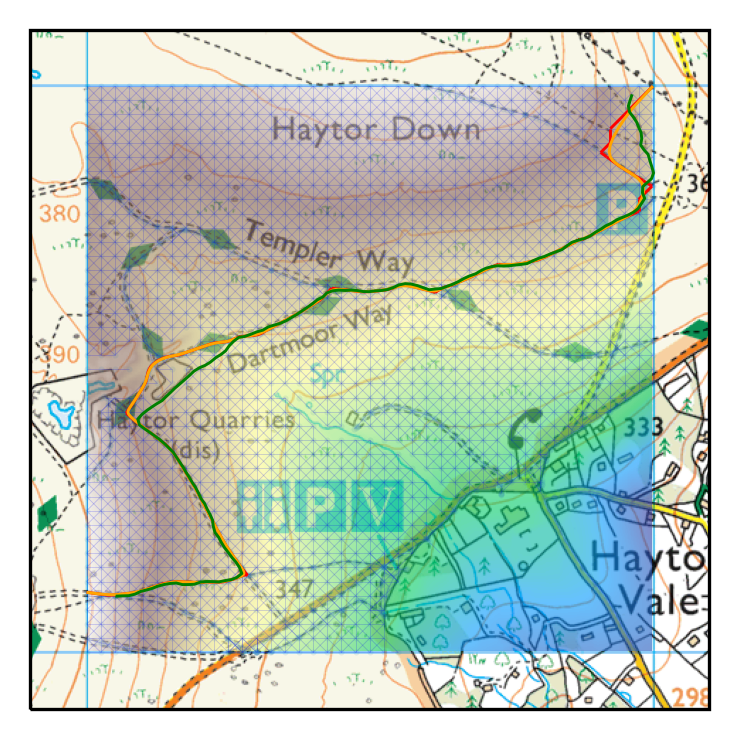

Length Score is 1999.7635582645842
Angle Score is 1191.3426880190118
Naismith Score is 32.67585874106396
Detailed-Path-Network Score is 26.0
Surface cost score is 559


C:\Users\User\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:59: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
C:\Users\User\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:85: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.


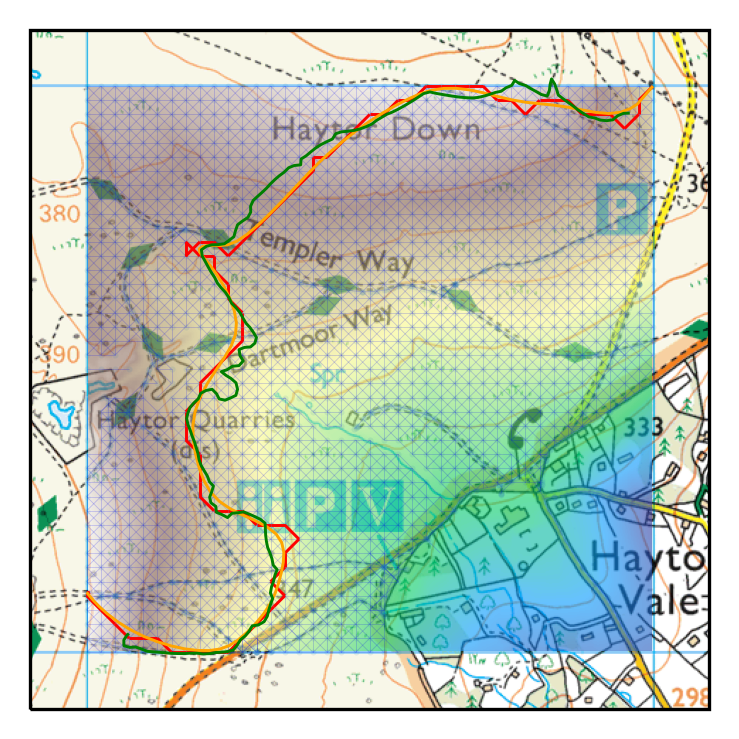

Length Score is 2447.9468676430915
Angle Score is 388.81956280591936
Naismith Score is 40.258588616802946
Detailed-Path-Network Score is 371.0
Surface cost score is 49


In [162]:
compare_routes(points,dpn_gpx,surface_cost_gpx,graph)

## Evaluating Routes
### int_dpn1 to dpn 1127

In [163]:
#from top_right to haytor rocks path
points = ['int_dpn1', 'dpn_1127']


In [164]:
dpn_gpx = open(os.path.join('Study_area', 'SX7677', 'Walked Routes', '2022-07-19_850029683_dpn intdpn1 dpn1127.gpx'),
               'r')
surface_cost_gpx = open(
    os.path.join('Study_area', 'SX7677', 'Walked Routes', '2022-07-19_850101971_surface cost intdpn1 dpn1127.gpx'), 'r')

C:\Users\User\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:21: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
C:\Users\User\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:47: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.


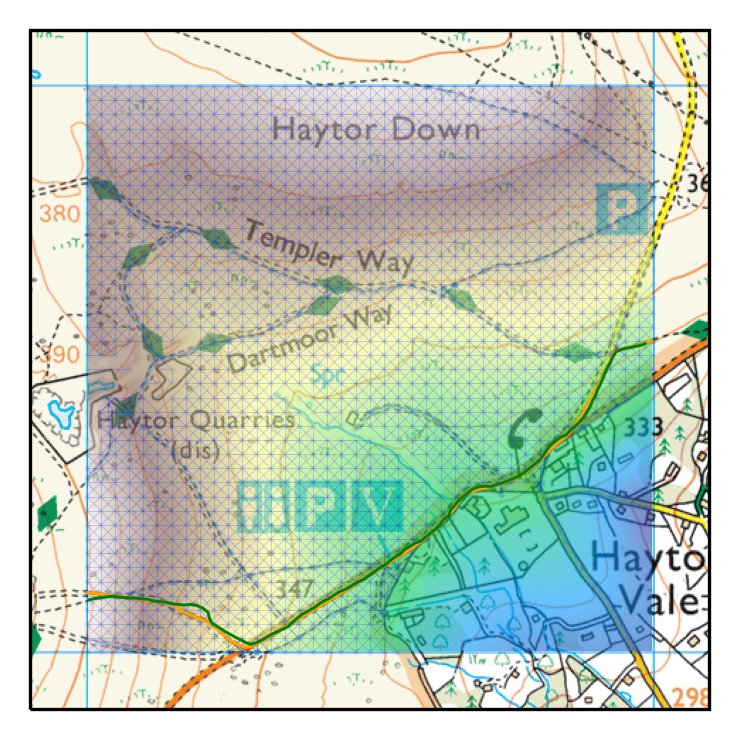

Length Score is 1243.5486236308175
Angle Score is 837.7375964654251
Naismith Score is 16.351583483569804
Detailed-Path-Network Score is 0.0
Surface cost score is 254


C:\Users\User\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:59: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
C:\Users\User\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:85: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.


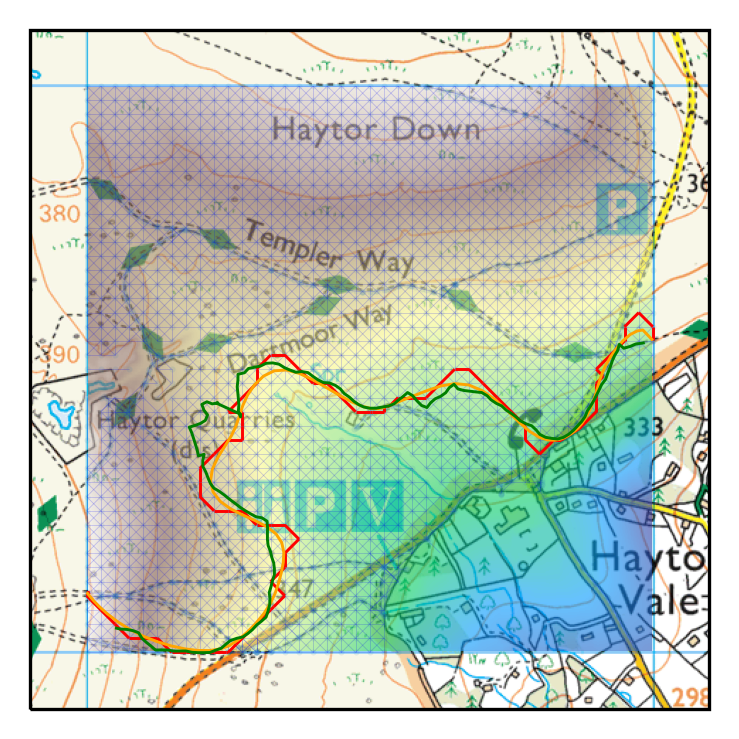

Length Score is 2167.0644470515344
Angle Score is 371.28183697654146
Naismith Score is 30.885285959469858
Detailed-Path-Network Score is 316.0
Surface cost score is 21


In [166]:
compare_routes(points,dpn_gpx,surface_cost_gpx,graph)